<a href="https://colab.research.google.com/github/jsalgadop/modelo-de-clasificacion/blob/main/Modeling_Cough_Taste_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrenamiento de Modelo de Clasificación
----
  

---


  Universidad : UTEC \\
  Curso       : Machine Learning \\
  Profesor    : Cristian López Del Alamo \\
  Tema        : Desarrollo de modelo de ML para detección temprana de COVID-19


 ----
Integrantes del grupo
+ Josué Sánchez
+ Julio Salgado
+ Richard Soriano
+ Rodrigo Guedes


## Abstract

Este proyecto busca desarrollar un modelo de clasificación para identificar pacientes con COVID-19 basándose únicamente en el sonido de su tos. Para ello, se analizaron 1430 muestras de audio de pacientes, que comprenden 1207 casos negativos, 150 positivos y 73 casos desconocidos. Estas muestras fueron obtenidas de fuentes confiables como COSWARA y Virufy.

Se aplicaron diversas técnicas de aprendizaje automático, incluyendo Support Vector Machines (SVM), árboles de decisión, regresión logística, Random Forest, Gradient Boosting, K-Nearest Neighbors (KNN) y XGBoost. Se empleó validación cruzada Stratified K-Fold para evaluar aleatoriamente el conjunto de datos y SMOTE para manejar el desequilibrio entre las tres clases. La optimización de hiperparámetros se realizó mediante GridSearchCV, utilizando características derivadas de los coeficientes cepstrales de Mel (MFCCs).

Tras la optimización de hiperparámetros y el manejo del desbalance, se observaron mejoras en las métricas. No obstante, la clasificación de la clase "Unknown" sigue presentando desafíos, evidenciado por un F1-Score persistentemente bajo (0.00-0.11). El AUC-ROC general varió entre 0.5833 y 0.6795, lo que indica una capacidad discriminativa moderada. Este enfoque, basado en el análisis del sonido de la tos, demuestra ser una herramienta prometedora y accesible para la detección de COVID-19. Se justifica la investigación futura para mejorar el rendimiento en clases minoritarias mediante técnicas avanzadas de balanceo y la incorporación de características de audio adicionales.


## Objetivo del proyecto

El proyecto propone implementar un modelo de clasificación de Machine Learning de alta precisión. Este modelo se entrenará utilizando un dataset compuesto por 1430 archivos de audio de grabaciones de tos de pacientes. Para la detección de COVID-19, se emplearán potentes algoritmos matemáticos y estadísticos. En la gráfica se visualiza el proceso general del desarrollo de la solución.

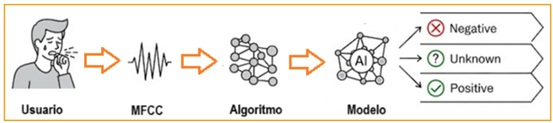


In [1]:
# Importar librerías necesarias
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from google.colab import drive

In [ ]:
# Definir funciones básicas
def matriz_confusion(y_true, y_pred, model):
    matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
    class_names = ["Negative", "Unknown", "Positive"]
    f2 = pd.DataFrame(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis], index=class_names, columns=class_names)
    sns.heatmap(f2, annot=True, cbar=None, cmap="Blues")
    plt.title("Confusion Matrix " + model)
    plt.tight_layout()
    plt.xlabel("Predicted")
    plt.ylabel("Real")
    plt.show()
    print("")

In [15]:
# Configurar repositorio con las muestras de voz
drive.mount('/content/drive/')
path = '/content/drive/MyDrive/UTEC/CD & IA/Ciclo III/Machine Learning/Trabajos/Práctica 02/DataSet/DataSet_Cough_Original/'

# Prueba de acceso al repositorio
from IPython.display import Audio
y, sr = librosa.load(path + "Negative/990_Negative_male_33.wav")
Audio(data=y, rate=sr)

## Distribución del dataset

El estudio en cuestión contempla el desarrollo de un modelo de clasificación para identificar rápidamente casos de COVID-19 basándose exclusivamente en el procesamiento de los sonidos producidos por la tos de los pacientes afectados, el cual aprovecha el uso de 1430 muestras de audio provenientes de fuentes certificadas como COSWARA y Virufy, las cuales conforman un dataset donde se puede advertir una distribución desbalanceada notoria de 1207 casos negativos, 150 positivos y 73 desconocidos para su evaluación con siete algoritmos de aprendizaje automático, a saber:

- Support Vector Machines (SVM)
- Decision Trees
- Logistic Regression
- Random Forest
- Gradient Boosting
- K-Nearest Neighbors (KNN)
- XGBoost



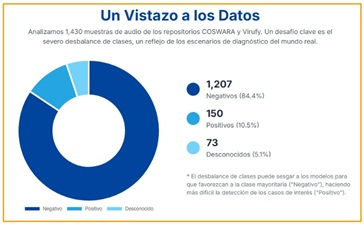

In [ ]:
# Procesar los archivos de voz del repositorio según las clases

# Leer casos positivos
pos_array = []
pos_directory = os.listdir(path + "Positive")
print(pos_directory)
for audio in pos_directory:
    y, sr = librosa.load(path + "Positive/" + audio)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    fv = np.concatenate([
        mfccs.mean(axis=1),  # Generar el promedio
        mfccs.std(axis=1),   # Generar la desviación estándar
        mfccs.min(axis=1),   # Generar el mínimo
        mfccs.max(axis=1)    # Generar el máximo
    ])
    pos_array.append(fv)

positive = np.array(pos_array)
positive = np.insert(positive, 0, 2, axis=1)

# Leer casos negativos
neg_array = []
neg_directory = os.listdir(path + "Negative")
print(neg_directory)
for audio in neg_directory:
    y, sr = librosa.load(path + "Negative/" + audio)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    fv = np.concatenate([
        mfccs.mean(axis=1),
        mfccs.std(axis=1),
        mfccs.min(axis=1),
        mfccs.max(axis=1)
    ])
    neg_array.append(fv)

negative = np.array(neg_array)
negative = np.insert(negative, 0, 0, axis=1)

# Leer casos desconocidos
unk_array = []
unk_directory = os.listdir(path + "Unknown")
print(unk_directory)
for audio in unk_directory:
    y, sr = librosa.load(path + "Unknown/" + audio)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    fv = np.concatenate([
        mfccs.mean(axis=1),
        mfccs.std(axis=1),
        mfccs.min(axis=1),
        mfccs.max(axis=1)
    ])
    unk_array.append(fv)

unknown = np.array(unk_array)
unknown = np.insert(unknown, 0, 1, axis=1)

# Consolidar el dataset con la definición de las características y el target
dataset = np.concatenate((positive, negative, unknown), axis=0)
np.random.shuffle(dataset)
y = dataset[:, 0].astype(int)
x = dataset[:, 1:]

## Naturaleza de los algoritmos seleccionados para el caso

Se describen brevemente los algoritmos considerados para el entrenamiento del dataset, justificando su inclusión mediante el análisis de sus fortalezas y debilidades.


**Support Vector Machines (SVM):** Algoritmo de aprendizaje supervisado que halla un hiperplano óptimo para separar clases, maximizando el margen. Maneja datos no lineales con kernels y es efectivo en alta dimensionalidad. Buena generalización, pero sensible a la elección de kernel y parámetros, y costoso en datasets grandes.


**Decision Tree:** Modelo que divide el espacio de características en regiones rectangulares con reglas de decisión. Fácil de interpretar, no requiere normalización y maneja datos categóricos/numéricos. Intuitivo y rápido, pero propenso al sobreajuste y sensible a variaciones de datos.


**Logistic Regression:** Modelo lineal que estima la probabilidad de pertenencia a una clase con una función logística. Simple, interpretable y rápido de entrenar. Eficaz para problemas linealmente separables, pero asume relación lineal.


**Random Forest:** Ensemble de árboles de decisión que promedia predicciones para reducir varianza y mejorar precisión. Robusto al sobreajuste, maneja muchas características y datos faltantes. Alta precisión, pero menos interpretable que un solo árbol y computacionalmente intensivo.


**Gradient Boosting:** Método ensemble que construye modelos secuencialmente, corrigiendo errores con optimización por gradiente. Potente para relaciones complejas, flexible con funciones de pérdida. Alta precisión, pero propenso al sobreajuste si no se ajustan parámetros, y requiere más tiempo de entrenamiento.


**K-Nearest Neighbors (KNN):** Algoritmo basado en instancias que clasifica un punto según la mayoría de sus k vecinos más cercanos. No paramétrico, simple de implementar y sin entrenamiento. Adaptable a cualquier distribución de datos, pero costoso en predicción, sensible a la escala de características y a la elección de k.


**XGBoost:** Implementación optimizada de Gradient Boosting, eficiente y escalable. Incluye regularización, maneja datos faltantes y es configurable. Alta precisión, eficiente en tiempo/memoria y popular en machine learning, pero complejo de ajustar y puede sobreajustar.



In [ ]:
# Definir los modelos y sus claves de hiperparámetros
models = {
    "SVM": {
        "model": SVC(probability=True, class_weight='balanced', random_state=42),
        "params": {
            'kernel': ['rbf', 'linear'],
            'C': [0.1, 1, 10]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(criterion="entropy", splitter="best", random_state=42),
        "params": {
            'max_depth': [3, 4, 6],
            'min_samples_leaf': [5, 10]
        }
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=3000, class_weight='balanced', random_state=0),
        "params": {
            'C': [0.1, 1, 10],
            'solver': ['lbfgs', 'liblinear']
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(class_weight='balanced', random_state=0),
        "params": {
            'max_depth': [3, 4, 6],
            'n_estimators': [100, 200],
            'min_samples_leaf': [5, 10]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=0),
        "params": {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 4]
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(metric='euclidean'),
        "params": {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance']
        }
    },
    "XGBoost": {
        "model": XGBClassifier(eval_metric='mlogloss', random_state=42),
        "params": {
            'max_depth': [3, 4],
            'learning_rate': [0.01, 0.1],
            'n_estimators': [100, 200],
            'min_child_weight': [3, 5]
        }
    }
}

## Estrategia para el desarrollo del modelamiento

Antes de presentar los resultados de la evaluación de cada modelo, se detallará la estrategia utilizada para el desarrollo del presente modelo de clasificación. Esta estrategia ha implicado la aplicación de diversos mecanismos de aprendizaje supervisado para el ajuste fino de las métricas establecidas.

Se evaluaron siete algoritmos de clasificación (SVM, Árbol de Decisión, Regresión Logística, Random Forest, Gradient Boosting, KNN y XGBoost). Cada uno se optimizó con GridSearchCV, usando el puntaje F1 ponderado. La validación se hizo con Stratified K-Fold (5 particiones) y se aplicó SMOTE para desbalance de clases (Unknown y Positive). Las características se estandarizaron con StandardScaler.

La evaluación del modelo se realiza con múltiples métricas: matriz de confusión normalizada (mapa de calor), reporte de clasificación (precisión, recall, F1-score por clase y promedios) y AUC-ROC (OvR). Por ejemplo, XGBoost (mejores parámetros: learning_rate: 0.1, max_depth: 4, min_child_weight: 3, n_estimators: 200) obtuvo un AUC-ROC de 0.6536, precisión global del 82% y F1-score ponderado de 0.81. Sin embargo, el rendimiento es bajo en la clase Unknown (F1-score: 0.05) y moderado en Positive (F1-score: 0.48) debido al desequilibrio y escasez de datos.

La reproducibilidad se asegura con una semilla fija. A pesar de la robustez del proceso, el bajo rendimiento en la clase 'Unknown' y un AUC-ROC moderado sugieren limitaciones, quizás por la calidad de las características MFCC o el solapamiento entre clases. La búsqueda de hiperparámetros y SMOTE aumentan la complejidad computacional. El proyecto aborda la clasificación de audios, pero el desempeño limitado en clases minoritarias indica la necesidad de explorar características adicionales (espectrogramas o temporales) o algoritmos avanzados como redes neuronales para optimizar la generalización.

## Tiempo de ejecución

De acuerdo a los laboratorios ejecutados, el tiempo promedio de entrenamiento bordea las 2 horas, por lo que se recomienda ponerlo en marcha solo en caso que sea necesario para los fines académicos correspondientes.

Mounted at /content/drive/
['1037_Positive_male_27.wav', '1041_Positive_male_39.wav', '1066_Positive_male_23.wav', '1077_Positive_female_20.wav', '1082_Positive_male_26.wav', '1084_Positive_male_25.wav', '1090_Positive_male_28.wav', '1099_Positive_male_65.wav', '1113_Positive_male_49.wav', '1119_Positive_male_24.wav', '1146_Positive_female_33.wav', '1164_Positive_male_25.wav', '1176_Positive_female_50.wav', '1180_Positive_male_23.wav', '1189_Positive_male_25.wav', '1192_Positive_male_28.wav', '1198_Positive_male_22.wav', '1210_Positive_female_22.wav', '1258_Positive_female_33.wav', '125_Positive_male_51.wav', '1260_Positive_male_30.wav', '1266_Positive_male_40.wav', '1280_Positive_female_50.wav', '1293_Positive_male_24.wav', '1298_Positive_male_24.wav', '130_Positive_male_25.wav', '1315_Positive_male_23.wav', '1325_Positive_male_38.wav', '1328_Positive_male_40.wav', '132_Positive_female_25.wav', '1332_Positive_male_2.wav', '1341_Positive_female_20.wav', '1358_Positive_male_25.wav', '13

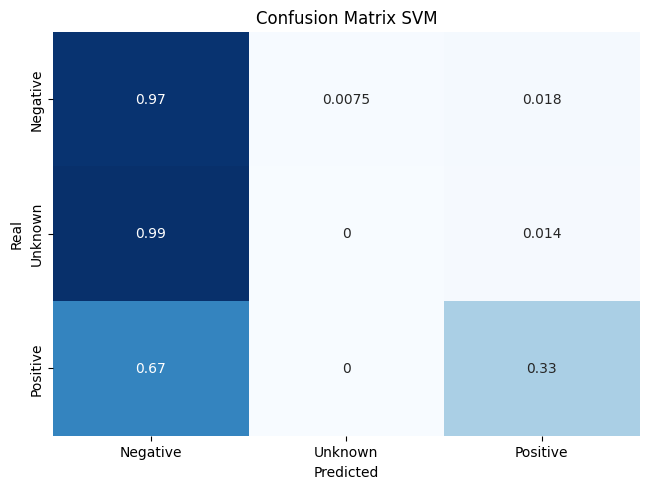


SVM
Mejores parámetros: {'C': 10, 'kernel': 'rbf'}
AUC-ROC (OvR): 0.6795
              precision    recall  f1-score   support

    Negative       0.87      0.97      0.92      1207
     Unknown       0.00      0.00      0.00        73
    Positive       0.68      0.33      0.45       150

    accuracy                           0.86      1430
   macro avg       0.52      0.44      0.46      1430
weighted avg       0.81      0.86      0.82      1430




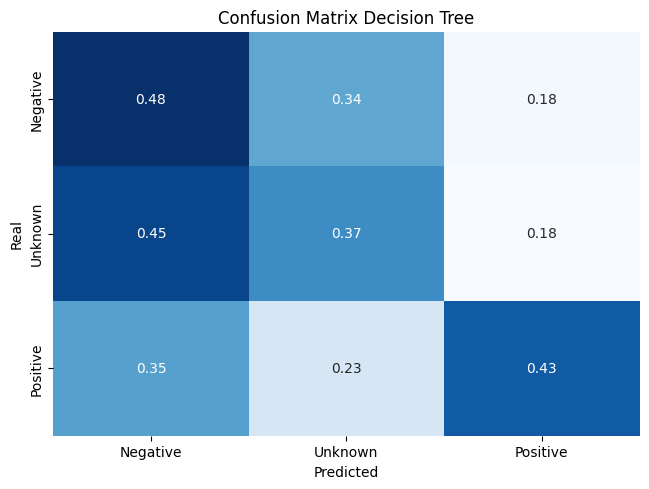


Decision Tree
Mejores parámetros: {'max_depth': 6, 'min_samples_leaf': 5}
AUC-ROC (OvR): 0.5833
              precision    recall  f1-score   support

    Negative       0.87      0.48      0.62      1207
     Unknown       0.06      0.37      0.10        73
    Positive       0.21      0.43      0.28       150

    accuracy                           0.47      1430
   macro avg       0.38      0.42      0.33      1430
weighted avg       0.76      0.47      0.55      1430




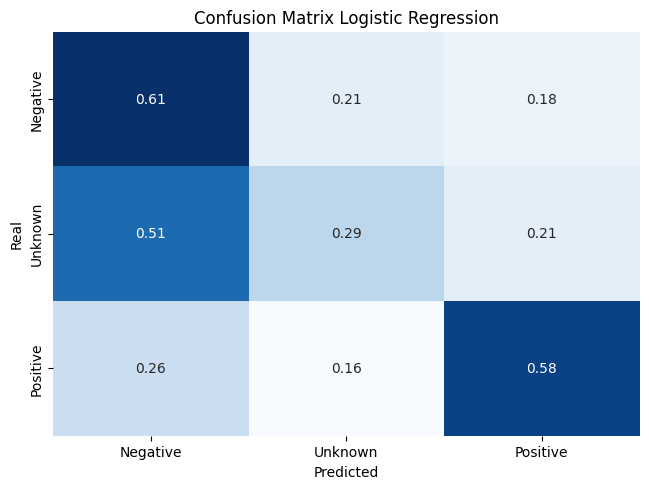


Logistic Regression
Mejores parámetros: {'C': 10, 'solver': 'lbfgs'}
AUC-ROC (OvR): 0.6463
              precision    recall  f1-score   support

    Negative       0.91      0.61      0.73      1207
     Unknown       0.07      0.29      0.11        73
    Positive       0.27      0.58      0.37       150

    accuracy                           0.59      1430
   macro avg       0.42      0.49      0.40      1430
weighted avg       0.80      0.59      0.66      1430




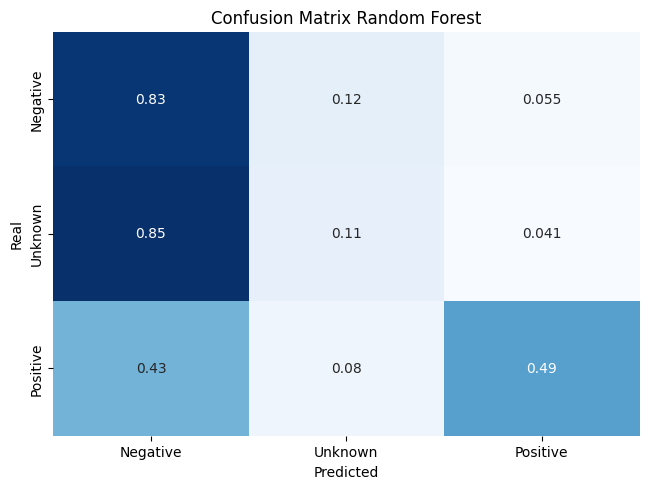


Random Forest
Mejores parámetros: {'max_depth': 6, 'min_samples_leaf': 5, 'n_estimators': 200}
AUC-ROC (OvR): 0.6690
              precision    recall  f1-score   support

    Negative       0.89      0.83      0.86      1207
     Unknown       0.05      0.11      0.07        73
    Positive       0.52      0.49      0.51       150

    accuracy                           0.76      1430
   macro avg       0.48      0.48      0.48      1430
weighted avg       0.81      0.76      0.78      1430




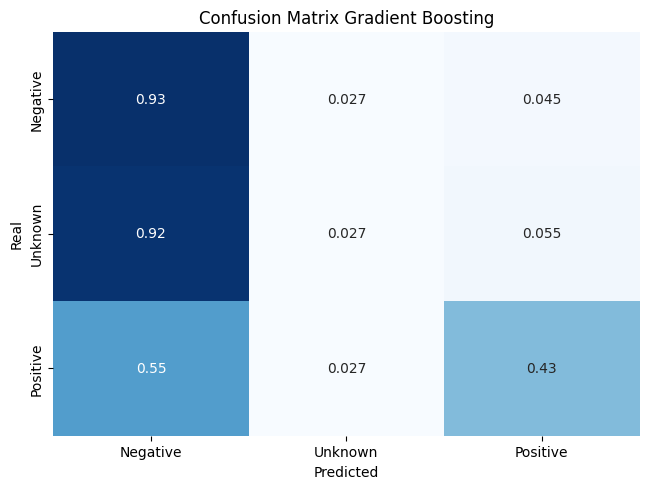


Gradient Boosting
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
AUC-ROC (OvR): 0.6565
              precision    recall  f1-score   support

    Negative       0.88      0.93      0.91      1207
     Unknown       0.05      0.03      0.04        73
    Positive       0.52      0.43      0.47       150

    accuracy                           0.83      1430
   macro avg       0.49      0.46      0.47      1430
weighted avg       0.80      0.83      0.82      1430




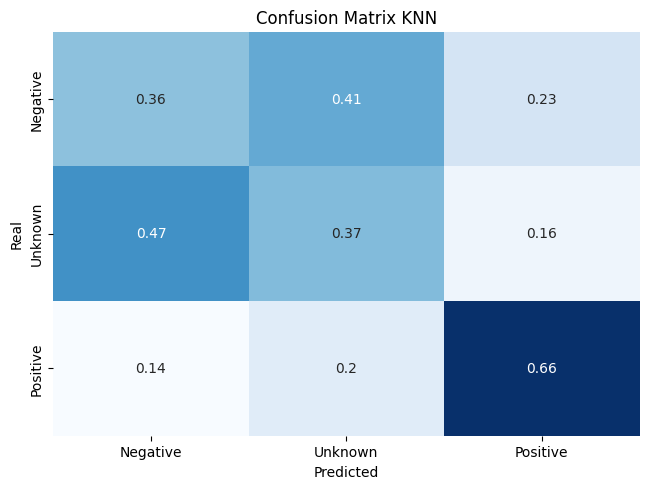


KNN
Mejores parámetros: {'n_neighbors': 3, 'weights': 'uniform'}
AUC-ROC (OvR): 0.6220
              precision    recall  f1-score   support

    Negative       0.89      0.36      0.51      1207
     Unknown       0.05      0.37      0.09        73
    Positive       0.25      0.66      0.37       150

    accuracy                           0.39      1430
   macro avg       0.40      0.46      0.32      1430
weighted avg       0.78      0.39      0.47      1430




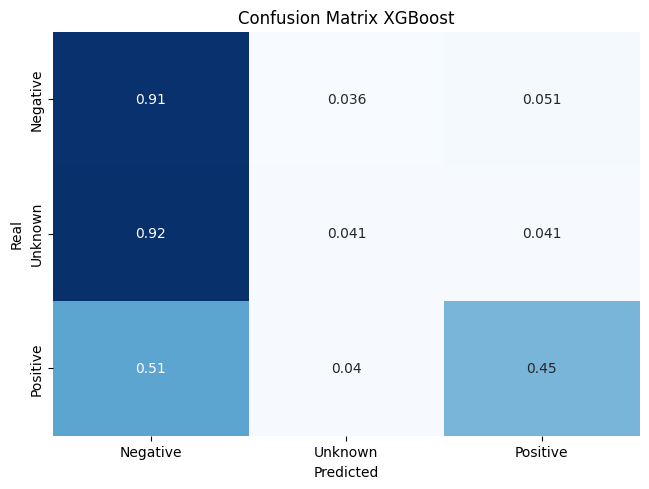


XGBoost
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 200}
AUC-ROC (OvR): 0.6536
              precision    recall  f1-score   support

    Negative       0.88      0.91      0.90      1207
     Unknown       0.06      0.04      0.05        73
    Positive       0.51      0.45      0.48       150

    accuracy                           0.82      1430
   macro avg       0.48      0.47      0.47      1430
weighted avg       0.80      0.82      0.81      1430




In [ ]:
# Implementar K-fold cross-validation con SMOTE y GridSearchCV, sin desestimar la estandarización

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, config in models.items():
    model = config["model"]
    param_grid = config["params"]
    y_true_all = []
    y_pred_all = []
    y_prob_all = []

    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Estandarizar los datos aplicando StandardScaler
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train)
        x_test_scaled = scaler.transform(x_test)

        # Aplicar SMOTE al conjunto de entrenamiento
        smote = SMOTE(random_state=42)
        x_train_res, y_train_res = smote.fit_resample(x_train_scaled, y_train)

        # Buscar los mejores hiperparámetros con GridSearchCV
        grid = GridSearchCV(model, param_grid, cv=StratifiedKFold(3, shuffle=True, random_state=42), scoring='f1_weighted', n_jobs=-1)
        grid.fit(x_train_res, y_train_res)

        # Ejecutar el modelo con los mejores estimadores
        best_model = grid.best_estimator_
        y_pred = best_model.predict(x_test_scaled)
        y_prob = best_model.predict_proba(x_test_scaled)  # Obtener las probabilidades

        y_true_all.append(y_test)
        y_pred_all.append(y_pred)
        y_prob_all.append(y_prob)

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)
    y_prob_all = np.concatenate(y_prob_all)

    # Presentar la matriz de confusión
    matriz_confusion(y_true_all, y_pred_all, model_name)

    # Calcular la métrica AUC-ROC (One-vs-Rest)
    auc_roc = roc_auc_score(y_true_all, y_prob_all, multi_class='ovr')

    # Mostrar los índices de rendimiento para cada modelo
    report = classification_report(y_true_all, y_pred_all, target_names=["Negative", "Unknown", "Positive"])

    print(model_name)
    print("Mejores parámetros:", grid.best_params_)
    print(f"AUC-ROC (OvR): {auc_roc:.4f}")
    print(report)
    print("")